In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tifffile as tf
import pickle
from datetime import datetime
import os
from skimage.color import label2rgb
import sys
sys.path.append("../../")
from functions_EDX import *

### EDX colors of interest

In [3]:
indices = [3,4,6,1,9,7]
colors = [[1,0,0], [0,1,0], [0,0,1], [0,1,1], [1,0,1], [1,1,0]]

### load the stack of haadfs, SAM masks, abundance maps

In [4]:
# haadf stack
haadf_stack = tf.imread("../../../../primary_data/main_mosaic_5by6_haadf.tiff")  

# location of SAM masks
masks_path = '../../../../primary_data/main_mosaic_6by5/SAM_masks/'

# abundance maps
abundance_maps = np.load("../../../../primary_data/abundance_maps.npz")['arr_0']
print('abundance maps shape',abundance_maps.shape)

abundance maps shape (11, 1024, 1024, 30)


### Apply the SAM/EDX routine to a single tile

In [5]:
tile_idx = 8

# Haadf
haadf = haadf_stack[tile_idx,:,:] 
    
# Get the masks
file = open(os.path.join(masks_path,'tile_%02d.pkl' % tile_idx),'rb')
masks = pickle.load(file)

### Show the color EDX image

In [6]:
# Abundance for a single tile
abundance_tile = abundance_maps[indices,:,:,tile_idx]
rgb_image = np.zeros((3,abundance_tile.shape[1], abundance_tile.shape[2]))

for x in range(rgb_image.shape[1]):
    for y in range(rgb_image.shape[2]):
        idx = np.argmax(abundance_tile[:,x,y])
        rgb_image[0,x,y] = colors[idx][0] * abundance_tile[idx,x,y]
        rgb_image[1,x,y] = colors[idx][1] * abundance_tile[idx,x,y]
        rgb_image[2,x,y] = colors[idx][2] * abundance_tile[idx,x,y]
        
edx_rgb = (np.copy(rgb_image[:,:,:]).transpose(1,2,0)*255).astype('uint8')

### Compare SAM with SAM-EDX

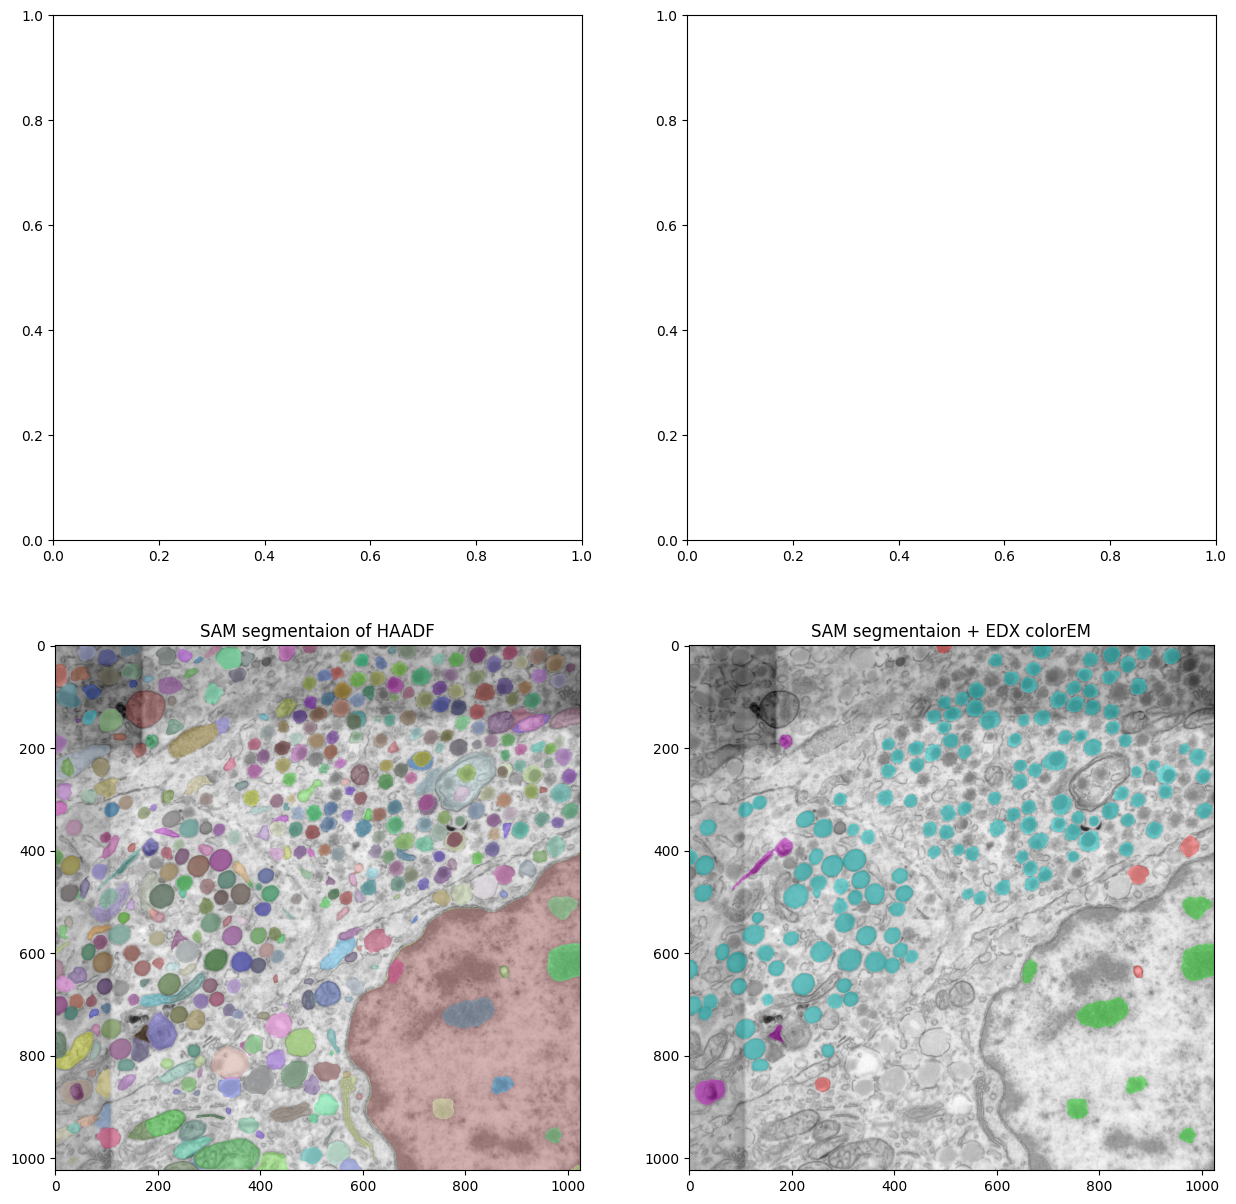

In [9]:
%matplotlib inline
f,ax = plt.subplots(2,2,figsize=(15,15))

#ax[0][0].imshow(haadf,cmap='gray')
#ax[0][0].set_title('HAADF image',fontsize=20)

#ax[0][1].imshow(edx_rgb)
#ax[0][1].set_title('EDX ColorEM',fontsize=20)

ax[1][0].imshow(haadf,cmap='gray')
ax[1][0].imshow(show_anns(masks,display=False))
ax[1][0].set_title('SAM segmentaion of HAADF',fontsize=12)


ax[1][1].imshow(haadf,cmap='gray')
SamEDXImg,img_clr_idx = show_anns_EDX(masks,abundance_tile,colors,display=False,alpha = 0.35,min_purity=0.3)
ax[1][1].imshow(SamEDXImg)
ax[1][1].set_title('SAM segmentaion + EDX colorEM',fontsize=12)

plt.show()